<h1> Exercises 2: More complex radar data!</h1>
In this notebook we have a more complex example of beamforming and matched filter. The majority of the complexity will be seen in the antenna position declaration, since the beamforming algorithm and the matched filter algorithm should remain the same. 

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import time

<h5> 1. Beamforming </h5>

To help understand some of the ways to visualize radar data better, we have provided some processed data and some examples of Python plotting code to play around with. First we will go through the process of beamforming and show the bird eye view (BEV) heatmaps we can recover from this.
For beamforming, it requires knowing a few details about the antenna array that captured the data. We will describe it in more detail below.
For the rest of this section, the horizontal dimension will be defined as *x*, vertical as *z*, and depth will be defined by *y*. 

First, we load the data provided.


In [18]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

# loading data that is given
filename = r"data_008"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape


Now we will describe the antenna array pattern. The data provided was taken by scanning a much smaller radar and set of antennas (same as exercise_1.ipynb) to emulate a larger antenna array. This is also known as SAR (Synthetic Aperture Radar), which you should have seen in the pre-recorded lectures.

The scanning radar has 1 transmitter and 4 receivers. The receivers are spaced $\lambda$/2 apart, and the transmitter is offset by 0.005 + $\lambda$/2. 
The receiver antenna pattern is defined in the variable *rx_pos*. The transmitter locations are only needed in the matched filter code, which you will see more details there.

Then, we scan the radar horizontally and vertically. In this portion, only the horizontal scan is used (we will aribitarily pick one vertical location and use that), and we leave the implementation of recreating the 2D image for the evaluation.

The radar is moved along the x-axis 80 times, each time moving by a distance $\lambda$, which you can see is defined by the variable *x_pos*. Finally, *ant_pos* defines the total receiver antenna scanning pattern. 

In [16]:
# define the antenna spacing
lm = 3e8/77e9 # define lambda for the antenna spacing

# this is the receiver positions
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) * lm / 2

# this is the locations of the locations of the radar (we are moving it by lambda) 
x_pos = -(np.reshape(np.arange(1,81,dtype=float),(-1,1))) * lm

# antenna positions for all receivers in the entire scan. /lm so that we don't have two factors of lm when we multiply them
ant_pos = np.reshape(rx_pos.T * x_pos/lm,(-1,1))
ant_pos = ant_pos - ant_pos[0] # make sure first location is 0
x_pos = x_pos - x_pos[0] # make sure first location is 0

[[ 0.        ]
 [-0.0038961 ]
 [-0.00779221]
 [-0.01168831]
 [-0.01558442]
 [-0.01948052]
 [-0.02337662]
 [-0.02727273]
 [-0.03116883]
 [-0.03506494]
 [-0.03896104]
 [-0.04285714]
 [-0.04675325]
 [-0.05064935]
 [-0.05454545]
 [-0.05844156]
 [-0.06233766]
 [-0.06623377]
 [-0.07012987]
 [-0.07402597]
 [-0.07792208]
 [-0.08181818]
 [-0.08571429]
 [-0.08961039]
 [-0.09350649]
 [-0.0974026 ]
 [-0.1012987 ]
 [-0.10519481]
 [-0.10909091]
 [-0.11298701]
 [-0.11688312]
 [-0.12077922]
 [-0.12467532]
 [-0.12857143]
 [-0.13246753]
 [-0.13636364]
 [-0.14025974]
 [-0.14415584]
 [-0.14805195]
 [-0.15194805]
 [-0.15584416]
 [-0.15974026]
 [-0.16363636]
 [-0.16753247]
 [-0.17142857]
 [-0.17532468]
 [-0.17922078]
 [-0.18311688]
 [-0.18701299]
 [-0.19090909]
 [-0.19480519]
 [-0.1987013 ]
 [-0.2025974 ]
 [-0.20649351]
 [-0.21038961]
 [-0.21428571]
 [-0.21818182]
 [-0.22207792]
 [-0.22597403]
 [-0.22987013]
 [-0.23376623]
 [-0.23766234]
 [-0.24155844]
 [-0.24545455]
 [-0.24935065]
 [-0.25324675]
 [-0.25714

In [17]:
def steering_vec(theta,locs):
    '''
    Calculates the steering vector based on the angle given (theta) and the angtenna array locations. 
    
    Paramters: 
    - theta: angle of arrival that we are calculating the steering vector for (radians)
    - locs: antenna locations

    Returns:
    - bf_vector: steering vector
    '''

    cos_theta = np.cos(theta) # angle that the signal is coming from 
    bf_vector = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))

    return bf_vector

In some cases, there is a lot of self-interference between the antennas when we scan, and it appears as a very very strong signal very close to the radar. Thus, we sometimes will pass the raw signal through a highpass filter to get rid of the strong signals at the lower frequencies. You can try with and without this highpass filter and see how it affects the images. 

In [19]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
def beamform_1d(beat_freq_data, theta_s, theta_e,theta_res,locs):
    """
    Performs 1D beamforming along the azimuth (horizontal) dimension, this results in a bird eye view image.

    Paramters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
    - theta_s: first angle that you want to start computing 
    - theta_e: last angle that you want to compute 
    - theta_res: resolution of the angles you want to compute
    - locs: antenna locations

    Returns:
    - sph_pwr: beamformed result
    - theta: the array of the angles computed
    """
    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        start_time = time.time()
        Vec = steering_vec(theta[kt],locs)
        # Vec = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))
        VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1))
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data),VecRFI), axis=(0)))        
        print("Processed angle (%.2f) took %.2f sec" % (theta[kt]*180/np.pi, start_time - time.time()), end='\r')
    return sph_pwr, theta

Take the first verical scan, and the range FFT of the raw ADC data.

In [22]:
# just look at one vertical dimension since we are not using elevation
X = raw_data[:,0,:,:,:]
beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq,(-1,adc_samples))

Run the beamforming algorithm! Here we are doing theta from 70 degrees to 130 degrees.

In [23]:
# define the azimuth angles (horizontal FOV) that we want to look at 
theta_s, theta_e = 70, 130
theta_res = 1
bf_output, theta = beamform_1d(beat_freq, theta_s,theta_e,theta_res,ant_pos)

Running this many iterations: 61 


Once we've performed beamforming on this 1D array, we can plot the corresponding images. In this example below, we have plotted the birds eye view for you. You can play around with the normalization to see how different thresholds impact the final image and what reflectors you can see. 

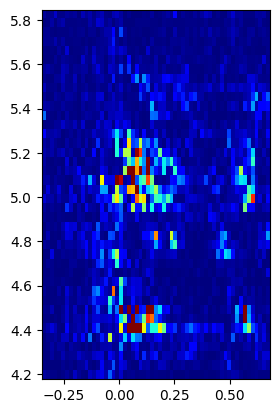

In [25]:
plot_lim_y = [100,140]
plot_lim_x = [70 - theta_s,129 - theta_s]
to_plot = bf_output
to_plot = to_plot[plot_lim_x[0]:plot_lim_x[1],plot_lim_y[0]:plot_lim_y[1]]
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1))) 
to_plot = to_plot[:,::-1]**2
plt.imshow(abs((to_plot).T), extent=[theta[plot_lim_x[0]]-np.pi/2, theta[plot_lim_x[1]]-np.pi/2,plot_lim_y[0] * 0.041763,plot_lim_y[1] * 0.041763],cmap = 'jet',  vmin=0, vmax=0.7) # this is giving the y axis in meters, and x axis in angles 

<h5> 2. Matched Filter:</h5> 
Here we will compute the matched filter output but for a more complex antenna pattern. If you take a look at this function and the one in exercise_1.ipynb it should be virtually the same. 

In [26]:
######## 1D Imaging in Cartesian #############
def matched_filter_1d(raw_data_1d, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx):
    """
    Computes the 1D matched filter result for raw data, this is done along the X, Y dimensions (results in a birds eye view image).

    Paramters:
    - raw_data_1d: raw ADC data (size: num Tx * num Rx, num ADC samples)
    - num_x_cells: discrete locations in X (horizontal) that you want to compute the power of
    - num_y_cells: discrete locations in Y (range/depth) that you want to compute the power of
    - x_radar_tx: positions of the transmitters 
    - x_radar_rx: positions of the receivers 

    Returns:
    - MF_output: matched filter output
    """
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)

    MF_output = np.zeros((len(num_x_cells),len(num_y_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for j,cell_y in enumerate(num_y_cells):
                start_time = time.time()

                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2)
                cell_dist = cell_dist + 0.15 # account for range bias
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples,axis=1) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)
                MF_output[i,j] = MF_output[i,j] + np.sum((raw_data_1d *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f) took %.2f sec" % (cell_x,cell_y, start_time - time.time()), end='\r')
    return MF_output 

Now we will reshape the raw data and create the cartesian coordinates that we will calculate outputs for. 
Again because this is a 1D matched fitler implementation, we will take a sample from the center of the 2D aperture. *num_x_cells* denotes the x coordinates that we will compute correlations for, and *num_y_cells* will denote the y coordinates that we compute correlations for. 

We also will define the antenna positions for the transmitter and the receivers. Again, to match the dimensions of the receivers when doing matrix addition, we create an array of the transmitter locations where every 4 spots will be the same location so as to match the number of receivers when calculating round trip distance. The transmitter location moves by $\lambda$/2 each time (which is just the *x_pos* array), and we repeat that 4 times for the 4 receivers. We then also have the shift the transmitter location by (0.005 + 3 $\lambda$/2). 

The receiver locations are just defined as *ant_pos*.

In [37]:
X = np.squeeze(raw_data[:,0,:,:,:]) # for matched filter we use the raw data directly!
X = np.reshape(X,(-1,adc_samples))

num_x_cells = np.arange(-1.5,1.5+0.025,0.05)
num_y_cells = np.arange(4.2,6.8,0.05)

x_radar_tx = np.reshape(np.repeat(x_pos,4),(-1,1)) - 0.005 - 3 * lm / 2
x_radar_rx = ant_pos

# print(x_pos)
MF_output = matched_filter_1d(X, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx)

Now we will plot the heatmap computed below.

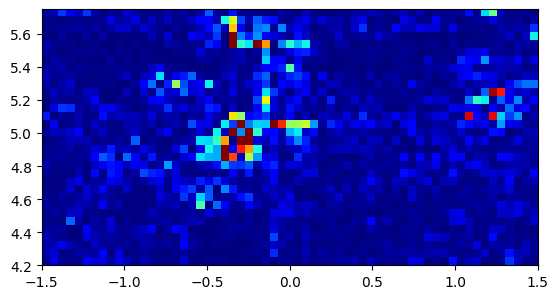

In [34]:
to_plot = MF_output
to_plot = to_plot/np.max(np.reshape(to_plot,(1,-1)))
to_plot = to_plot[:,:]**2
plt.imshow(abs((to_plot).T), extent=[num_x_cells[0], num_x_cells[-1], num_y_cells[0], num_y_cells[-1]],cmap = 'jet',  vmin=0, vmax=0.3) # this is giving the y axis in meters, and x axis in angles 

Now you should've seen two examples of doing 1D beamforming and matched filter. In these cases, we are assuming the antenna array is one dimensional, so the antennas only have differing x-positions and the same z-positions. In the next notebook, we will be evaluating your code. In that case you will extend the 1D beamforming and matched filter to 2D. This means in these examples we will use the fully scanned locations, and this will mean you need to take into account the z-positions as well!